#NEXT DAY RAIN PREDICTION


## Import Libraries

In [52]:
# Data wrangling, analysis, and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-modeling stage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modeling stage
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation stage
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay



## LOAD AND UNDERSTAND THE DATASET

In [54]:
df = pd.read_csv('Weather_Data.csv')

In [3]:
df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2/1/2008,19.5,22.4,15.6,6.2,0.0,W,41,S,SSW,...,92,84,1017.6,1017.4,8,8,20.7,20.9,Yes,Yes
1,2/2/2008,19.5,25.6,6.0,3.4,2.7,W,41,W,E,...,83,73,1017.9,1016.4,7,7,22.4,24.8,Yes,Yes
2,2/3/2008,21.6,24.5,6.6,2.4,0.1,W,41,ESE,ESE,...,88,86,1016.7,1015.6,7,8,23.5,23.0,Yes,Yes
3,2/4/2008,20.2,22.8,18.8,2.2,0.0,W,41,NNE,E,...,83,90,1014.2,1011.8,8,8,21.4,20.9,Yes,Yes
4,2/5/2008,19.7,25.7,77.4,4.8,0.0,W,41,NNE,W,...,88,74,1008.3,1004.8,8,8,22.5,25.5,Yes,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3271 non-null   object 
 1   MinTemp        3271 non-null   float64
 2   MaxTemp        3271 non-null   float64
 3   Rainfall       3271 non-null   float64
 4   Evaporation    3271 non-null   float64
 5   Sunshine       3271 non-null   float64
 6   WindGustDir    3271 non-null   object 
 7   WindGustSpeed  3271 non-null   int64  
 8   WindDir9am     3271 non-null   object 
 9   WindDir3pm     3271 non-null   object 
 10  WindSpeed9am   3271 non-null   int64  
 11  WindSpeed3pm   3271 non-null   int64  
 12  Humidity9am    3271 non-null   int64  
 13  Humidity3pm    3271 non-null   int64  
 14  Pressure9am    3271 non-null   float64
 15  Pressure3pm    3271 non-null   float64
 16  Cloud9am       3271 non-null   int64  
 17  Cloud3pm       3271 non-null   int64  
 18  Temp9am 

In [5]:
# Check for rows with null values

condition_null = df.isnull().any(axis=1)
df[condition_null]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


In [6]:
# Check for duplicated rows

condition_dupl = df.duplicated()
df[condition_dupl]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


### Sidenote on **RainToday**

In [7]:
# Create dataframe for only RainToday and Rainfall columns
df_RToday_RF = df[['RainToday','Rainfall']]

# Show the least RainFall value for records of RainToday = 1
condition = df['RainToday'] == 'Yes'
df_RToday_RF[condition].sort_values(by='Rainfall', ascending=True)

,RainToday,Rainfall
403,Yes,1.2
104,Yes,1.2
1677,Yes,1.2
2544,Yes,1.2
1823,Yes,1.2
...,...,...
1707,Yes,95.2
1104,Yes,99.4
2484,Yes,105.8
1425,Yes,109.4


**Comment**: The dataset **confirms** a rain for the day if the amount of rainfall (in millimeters) is at least 1.2 mm.

### Balanced or imbalanced dataset?

In [8]:
# Compute distribution of our target variable

df['RainTomorrow'].value_counts()

No     2422
Yes     849
Name: RainTomorrow, dtype: int64

**Comment**: The positive class (raining tomorrow) accounts for 35% of the dataset. This means we have a moderately imbalanced dataset.

## DATA PRE-PROCESSING

### Replace categorical 'Yes' and 'No' with 1 and 0

In [9]:
df = df.replace(['Yes', 'No'], [1, 0])

In [10]:
# Check transformed values for RainToday

df['RainToday'].value_counts()

0    2422
1     849
Name: RainToday, dtype: int64

In [11]:
# Check transformed values for RainTomorrow

df['RainTomorrow'].value_counts()

0    2422
1     849
Name: RainTomorrow, dtype: int64

**NOTE**: Although both RainToday and RainTomorrow have the same distributions of 1s and 0s, they are not equal for every row of the dataset.

### Add a new column called 'Month'


Why add a Month column?

Answer: Because climate depends on months. Certain months are more susceptible to rainfall than other months.

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.insert(1, 'Month', df['Date'].dt.month)
df.tail()

,Date,Month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
3266,2017-06-21,6,8.6,19.6,0.0,2.0,7.8,SSE,37,W,...,73,52,1025.9,1025.3,2,2,10.5,17.9,0,0
3267,2017-06-22,6,9.3,19.2,0.0,2.0,9.2,W,30,W,...,78,53,1028.5,1024.6,2,2,11.0,18.7,0,0
3268,2017-06-23,6,9.4,17.7,0.0,2.4,2.7,W,24,WNW,...,85,56,1020.8,1015.0,6,6,10.2,17.3,0,0
3269,2017-06-24,6,10.1,19.3,0.0,1.4,9.3,W,43,W,...,56,35,1017.3,1015.1,5,2,12.4,19.0,0,0
3270,2017-06-25,6,7.6,19.3,0.0,3.4,9.4,W,35,W,...,73,32,1018.6,1015.4,1,1,9.4,18.8,0,0


### Sidenote: When is the rainy season in Sydney?

In [14]:
df_monthlyrain = df[['Month', 'Rainfall']].groupby('Month').mean().reset_index()
df_monthlyrain

,Month,Rainfall
0,1,3.150181
1,2,4.323922
2,3,4.483871
3,4,5.264906
4,5,2.434194
5,6,5.900690
6,7,2.867391
7,8,1.976952
8,9,1.733846
9,10,2.205344


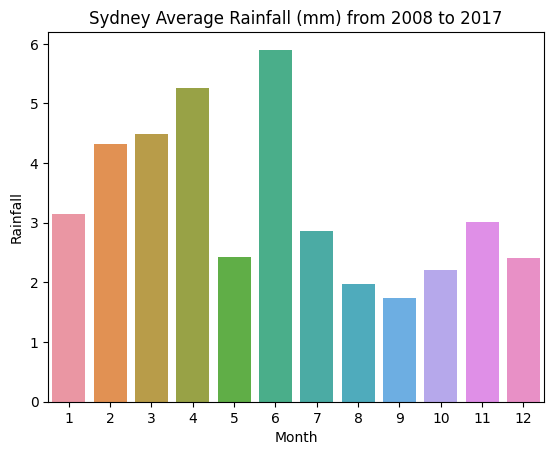

In [15]:
# Visualize rainfall vs. month

sns.barplot(data=df_monthlyrain, x='Month', y='Rainfall')
plt.title('Sydney Average Rainfall (mm) from 2008 to 2017')
plt.show()

**Comment**: Our dataset is aligned with the fact that Sydney's wettest months are from March to June.

### We can now delete the Date column as we no longer need it for modeling later.

In [16]:
df = df.drop('Date', axis=1)

## Convert categorical columns (with more than 2 values) into dummy variables

In [17]:
# Print column names for easy copy-pasting
df.columns

Index(['Month', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [18]:
cat_columns = ['Month', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

df = pd.get_dummies(df, columns=cat_columns, dtype=int)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MinTemp          3271 non-null   float64
 1   MaxTemp          3271 non-null   float64
 2   Rainfall         3271 non-null   float64
 3   Evaporation      3271 non-null   float64
 4   Sunshine         3271 non-null   float64
 5   WindGustSpeed    3271 non-null   int64  
 6   WindSpeed9am     3271 non-null   int64  
 7   WindSpeed3pm     3271 non-null   int64  
 8   Humidity9am      3271 non-null   int64  
 9   Humidity3pm      3271 non-null   int64  
 10  Pressure9am      3271 non-null   float64
 11  Pressure3pm      3271 non-null   float64
 12  Cloud9am         3271 non-null   int64  
 13  Cloud3pm         3271 non-null   int64  
 14  Temp9am          3271 non-null   float64
 15  Temp3pm          3271 non-null   float64
 16  RainToday        3271 non-null   int64  
 17  RainTomorrow  

**Comment**: We now have 77 features that are ready for modeling.

## MACHINE LEARNING MODELING

### Separate Features and the Target

In [20]:
features = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

### Create training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=8)

print(len(X_train), ':', len(y_train))
print(len(X_test), ':', len(y_test))

2616 : 2616
655 : 655


### TRAINING MODELS

I have to scale the continuous variables using the StandardScaler **without** affecting the categorical columns. Thus, I need to separate continous and categorical from our training set.

### Separate continuous and categorical features sub-dataframes

In [22]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindD

In [23]:
# Categorical features dataframe

X_train_categorical = X_train[['RainToday', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'WindGustDir_E',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_E', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
       'WindDir9am_S', 'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW',
       'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW',
       'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'WindDir3pm_N',
       'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW',
       'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW',
       'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW']]

X_train_categorical.tail()

,RainToday,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
2181,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2409,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
451,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


NOTE: The indices are retained after the train test split, which randomly selected 80% of the dataset for training.

In [24]:
# Numerical features dataframe

X_train_numerical = X_train[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                  'Cloud3pm', 'Temp9am', 'Temp3pm']]

X_train_numerical.tail()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
2181,10.3,17.2,0.2,2.6,1.2,54,13,22,65,49,1008.9,1008.3,7,7,13.0,16.9
2409,17.6,25.6,0.2,4.2,7.8,31,9,15,80,53,1027.7,1026.2,7,7,20.5,23.6
2033,19.3,28.7,0.0,10.6,13.1,52,7,22,65,51,1012.6,1009.4,0,0,25.1,28.3
1364,18.5,22.4,0.8,6.6,3.4,56,24,28,75,57,1015.1,1016.4,5,4,19.3,21.5
451,11.0,17.4,6.2,2.4,2.7,41,17,4,92,88,1020.5,1020.4,7,7,12.8,14.1


### Create a Confusion Matrix for our best model

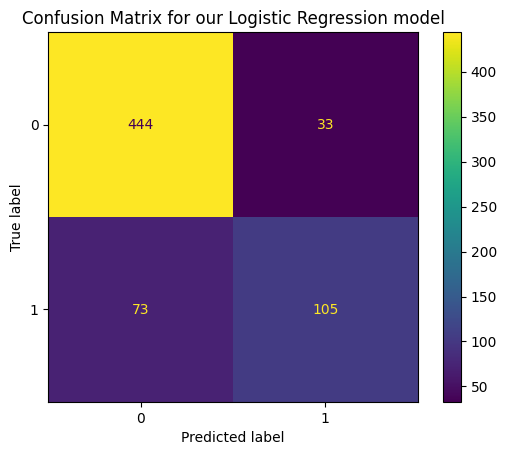

In [48]:
# Create the confusion matrix for our Logistic Regression model

cm = confusion_matrix(y_test, y_pred_lr)

cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()

plt.title('Confusion Matrix for our Logistic Regression model')
plt.show()